### The trainig workflow below was referring to

#### data processing & batch data generator:
https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb

#### model architecture: 
U-Net, a convolutional networks for biomedical image segmentation proposed by Ronneberger et al. (https://arxiv.org/abs/1505.04597) <br />
___

In [1]:
import os
import functools

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,Activation,MaxPooling2D,Dropout,concatenate,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import backend as K

from loss import bce_dice_loss,dice_loss

## Data Processing & Batch Data Generator

In [3]:
img_dir = "data/train"
label_dir = "data/train_masks"

In [4]:
df_train = pd.read_csv('data/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [5]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [6]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [7]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


### Input & Output Pipeline

In [8]:
img_shape = (512, 512, 3)
batch_size = 4

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair  
    img_str = tf.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)
    
    label_img_str = tf.read_file(label_path)
    
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only. 
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        # Translate both 
        output_img = tfcontrib.image.translate(output_img,
                                               [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img,
                                              [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize_images(label_img, resize)
        img = tf.image.resize_images(img, resize)
    
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
    
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.to_float(label_img) * scale
    img = tf.to_float(img) * scale 
    return img, label_img

In [13]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=8, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"
        
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    
    if shuffle:
        dataset = dataset.shuffle(num_x)
    
    # It's necessary to repeat our data for all epochs 
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [14]:
tr_cfg = {'resize': [img_shape[0], img_shape[1]],
          'scale': 1 / 255.,
          'hue_delta': 0.1,
          'horizontal_flip': True,
          'width_shift_range': 0.1,
          'height_shift_range': 0.1}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [15]:
val_cfg = {'resize': [img_shape[0], img_shape[1]],
           'scale': 1 / 255.}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [16]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)

val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

## Model Architecture

In [17]:
inputs = Input(shape=img_shape)

conv1_1 = Conv2D(32, (3, 3), padding='same')(inputs)
conv1_1 = BatchNormalization()(conv1_1)
conv1_1 = Activation('relu')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), padding='same')(conv1_1)
conv1_2 = BatchNormalization()(conv1_2)
conv1_2 = Activation('relu')(conv1_2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
    
conv2_1 = Conv2D(64, (3, 3), padding='same')(pool1)
conv2_1 = BatchNormalization()(conv2_1)
conv2_1 = Activation('relu')(conv2_1)
conv2_2 = Conv2D(64, (3, 3), padding='same')(conv2_1)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Activation('relu')(conv2_2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
    
conv3_1 = Conv2D(128, (3, 3), padding='same')(pool2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Activation('relu')(conv3_1)
conv3_2 = Conv2D(128, (3, 3), padding='same')(conv3_1)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Activation('relu')(conv3_2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)
drop3 = Dropout(0.4)(pool3)

conv4_1 = Conv2D(256, (3, 3), padding='same')(drop3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Activation('relu')(conv4_1)
conv4_2 = Conv2D(256, (3, 3), padding='same')(conv4_1)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Activation('relu')(conv4_2)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_2)
drop4 = Dropout(0.4)(pool4)

conv5_1 = Conv2D(512, (3, 3), padding = 'same')(drop4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Activation('relu')(conv5_1)
conv5_2 = Conv2D(512, (3, 3), padding = 'same')(conv5_1)
conv5_2 = BatchNormalization()(conv5_2)
conv5_2 = Activation('relu')(conv5_2)
drop5 = Dropout(0.4)(conv5_2)

up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5)
concat6 = concatenate([up6, conv4_2], axis=-1)
concat6 = BatchNormalization()(concat6)
concat6 = Activation('relu')(concat6)
conv6_1 = Conv2D(256, (3, 3), padding='same')(concat6)
conv6_1 = BatchNormalization()(conv6_1)
conv6_1 = Activation('relu')(conv6_1)
conv6_2 = Conv2D(256, (3, 3), padding='same')(conv6_1)
conv6_2 = BatchNormalization()(conv6_2)
conv6_2 = Activation('relu')(conv6_2)
drop6 = Dropout(0.4)(conv6_2)

up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6)
concat7 = concatenate([up7, conv3_2], axis=-1)
concat7 = BatchNormalization()(concat7)
concat7 = Activation('relu')(concat7)
conv7_1 = Conv2D(128, (3, 3), padding='same')(concat7)
conv7_1 = BatchNormalization()(conv7_1)
conv7_1 = Activation('relu')(conv7_1)
conv7_2 = Conv2D(128, (3, 3), padding='same')(conv7_1)
conv7_2 = BatchNormalization()(conv7_2)
conv7_2 = Activation('relu')(conv7_2)
drop7 = Dropout(0.4)(conv7_2)

up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop7)
concat8 = concatenate([up8, conv2_2], axis=-1)
concat8 = BatchNormalization()(concat8)
concat8 = Activation('relu')(concat8)
conv8_1 = Conv2D(64, (3, 3), padding='same')(concat8)
conv8_1 = BatchNormalization()(conv8_1)
conv8_1 = Activation('relu')(conv8_1)
conv8_2 = Conv2D(64, (3, 3), padding='same')(conv8_1)
conv8_2 = BatchNormalization()(conv8_2)
conv8_2 = Activation('relu')(conv8_2)

up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8_2)
concat9 = concatenate([up9, conv1_2], axis=-1)
concat9 = BatchNormalization()(concat9)
concat9 = Activation('relu')(concat9)
conv9_1 = Conv2D(32, (3, 3), padding='same')(concat9)
conv9_1 = BatchNormalization()(conv9_1)
conv9_1 = Activation('relu')(conv9_1)
conv9_2 = Conv2D(32, (3, 3), padding='same')(conv9_1)
conv9_2 = BatchNormalization()(conv9_2)
conv9_2 = Activation('relu')(conv9_2)

outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9_2)

model = Model(inputs=[inputs], outputs=[outputs])

In [18]:
epochs = 25
learning_rate = 1e-3
decay_rate = learning_rate/epochs

model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate), 
              loss=bce_dice_loss, 
              metrics=[dice_loss])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

### Model Training

In [19]:
save_model_path = 'model/weights2.hdf5'

callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=5,
                           verbose=1,
                           min_delta=1e-3),
             ModelCheckpoint(filepath=save_model_path, 
                             monitor='val_dice_loss', 
                             save_best_only=True, 
                             verbose=1)]

In [20]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=callbacks)

Epoch 1/25
1018/1018 [==============================] - 1259s 1s/step - loss: 0.0949 - dice_loss: 0.0509 - val_loss: 0.0971 - val_dice_loss: 0.0357

Epoch 00001: val_dice_loss improved from inf to 0.03569, saving model to model/weights2.hdf5
Epoch 2/25
1018/1018 [==============================] - 1142s 1s/step - loss: 0.0328 - dice_loss: 0.0163 - val_loss: 0.0267 - val_dice_loss: 0.0133

Epoch 00002: val_dice_loss improved from 0.03569 to 0.01328, saving model to model/weights2.hdf5
Epoch 3/25
1018/1018 [==============================] - 1143s 1s/step - loss: 0.0297 - dice_loss: 0.0145 - val_loss: 0.0885 - val_dice_loss: 0.0393

Epoch 00003: val_dice_loss did not improve from 0.01328
Epoch 4/25
1018/1018 [==============================] - 1143s 1s/step - loss: 0.0211 - dice_loss: 0.0105 - val_loss: 0.0172 - val_dice_loss: 0.0088

Epoch 00004: val_dice_loss improved from 0.01328 to 0.00884, saving model to model/weights2.hdf5
Epoch 5/25
1018/1018 [==============================] - 1143s

### Training Results

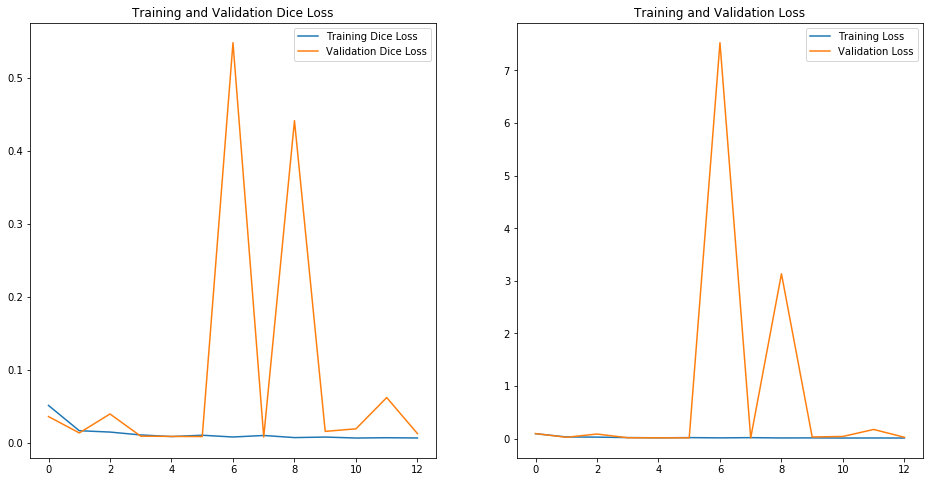

In [22]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [17]:
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                            'dice_loss': dice_loss})

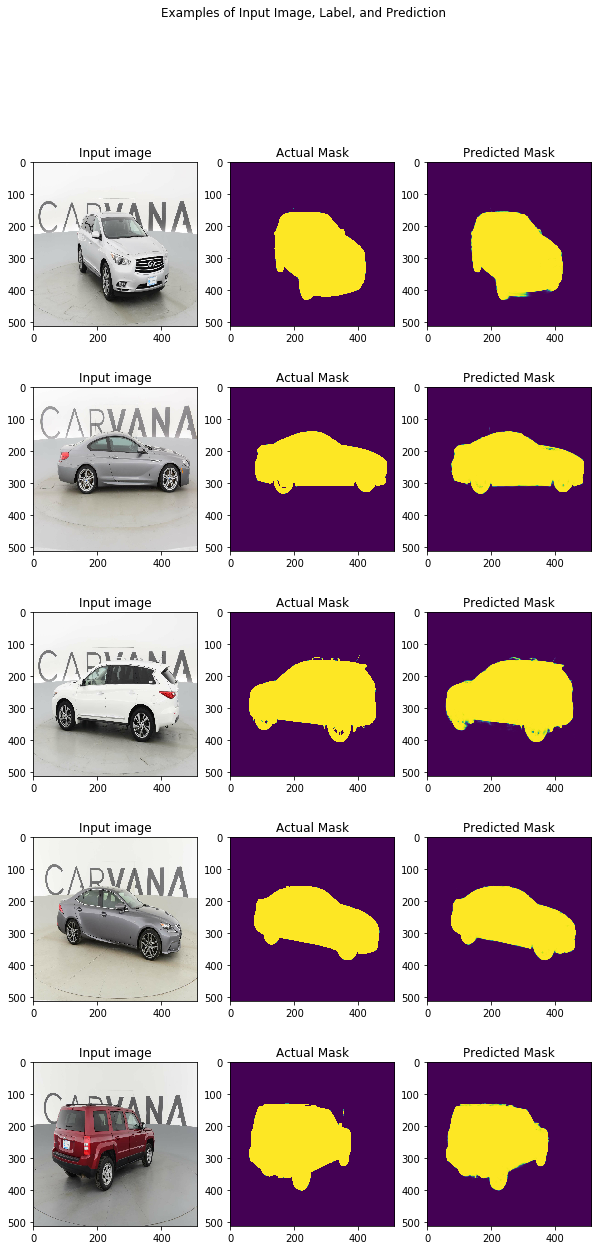

In [18]:
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]
    
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[0, :, :, 0])
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0])
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()